In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2
from sage.all import *
from utility import *

Pi = sage.symbolic.constants.pi

In [8]:
# Define here the equation defining your affine variety.
x,y,z,w = var('x, y, z, w', domain=CC)

alpha = var('alpha', domain=CC)
X = x*y*z + x^2 + y^2 + alpha*x + y # alpha in C^*
X = X.subs(alpha==1)

print(X)

x*y*z + x^2 + y^2 + x + y


In [9]:
# Check if X is smooth
X_vars = [x,y,z]
constraints = [X.diff(var) == 0 for var in X_vars]
solutions = solve(constraints, X_vars, solution_dict=True)
singularities = [point for point in solutions if X.subs(point).is_zero()]


if singularities:
    print(f"The variety is singular at the following points: {singularities}")
else:
    print("The variety is smooth.")

# Check if is_zero is reliable: Distrust the result if below values are close to 0.
for point in solutions:
    print(X.subs(point))

The variety is smooth.
-1/4
-1/4


# Defining the Lefschetz Bifibration

## The fibration $\pi$

The fibre over t in C is 1/4*(2*t + 6*x - z)*x*z + 1/16*(2*t + 6*x - z)^2 + x^2 + 1/2*t + 5/2*x - 1/4*z == 0
The model fibre over 0 is 1/4*(6*x - z)*x*z + 1/16*(6*x - z)^2 + x^2 + 5/2*x - 1/4*z == 0
Critical values: 6 
Critical points: 6


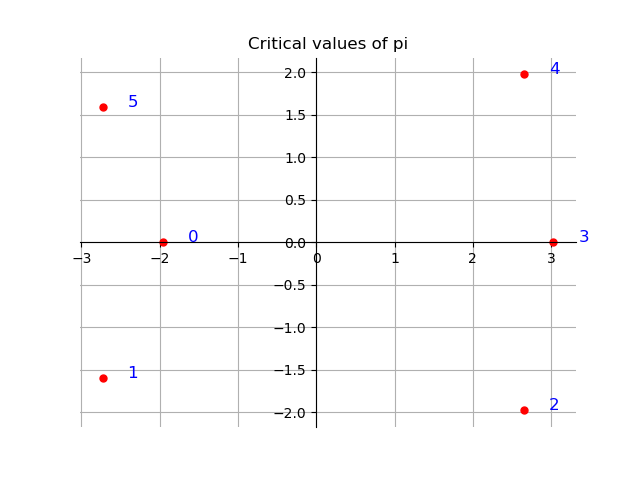

In [10]:
alpha, beta, gamma = var('alpha, beta, gamma', domain=CC)
pi = alpha*x + beta*y + gamma*z


pi = pi.subs({
    alpha: -3,
    beta: 2,
    gamma: 1/2
})

pi = LefschetzFibration([x,y,z], X, pi)
origin_fibre = 0
solvefor=y

t = var('t', domain=CC)

t_fibre = pi.get_fibre(t, solvefor)
print(f'The fibre over t in C is {t_fibre.simplify()==0}')
print(f'The model fibre over {origin_fibre} is {t_fibre.simplify().subs({t:origin_fibre})==0}')

crit_values_pi = sort_by_angle(pi.get_critical_values(), origin_fibre)
crit_points_pi = pi.get_critical_points()

print(f'Critical values: {len(crit_values_pi)} \nCritical points: {len(crit_points_pi)}')

plot_points_ordered(crit_values_pi, 'Critical values of pi', origin_fibre=origin_fibre)

### Criticality at Infinity

In [11]:
print(intersection_summary(pi))
intersection = intersection_at_infinity(pi)

for point in intersection:
    print(kernels(pi, point))
    print(point)

The hyperplane at infinity is given by 1.00000000000000*x*y*z == 0.
The fibration vanishes at [-3.00000000000000*x + 2.00000000000000*y + 0.500000000000000*z == 0].
Their intersection consists of [{x: 0, y: 1, z: -4, w: 0}, {x: 1, y: 0, z: 6, w: 0}, {x: 1, y: 3/2, z: 0, w: 0}].
None
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[                0  1.00000000000000 -4.00000000000000                 0]
{x: 0, y: 1, z: -4, w: 0}
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[1.00000000000000                0 6.00000000000000                0]
{x: 1, y: 0, z: 6, w: 0}
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[1.00000000000000 1.50000000000000                0                0]
{x: 1, y: 3/2, z: 0, w: 0}


## The fibration $\rho$

The expression of rho over t in C is 2*x + 1/4*z
Critical values: 6
Critical points: 6


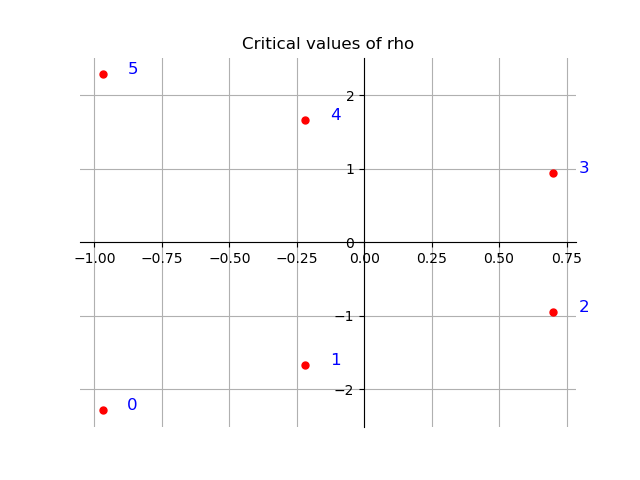

In [13]:
ar = var('ar', domain=CC)
br = var('br', domain=CC)

rho = ar*x + br*z

# rho = rho.subs({ar: 3*e^(2*Pi*I*-0.05).n(), br: 8*e^(2*I*Pi*0.08).n()})

rho = rho.subs({ar: 2, br: 1/4})
origin_fibre_rho = 0

rho_t = rho.subs(solvefor == t_fibre)
rho_0 = rho_t.subs(t==origin_fibre)

rho = LefschetzFibration([x,z], t_fibre.subs(t==origin_fibre), rho_0)

crit_points_rho = rho.get_critical_points()
crit_values_rho = sort_by_angle(rho.get_critical_values())

print(f'The expression of rho over t in C is {rho_t}')
print(f'Critical values: {len(crit_values_rho)}')
print(f'Critical points: {len(crit_points_rho)}')
plot_points_ordered(crit_values_rho, origin_fibre=origin_fibre_rho, title="Critical values of rho")


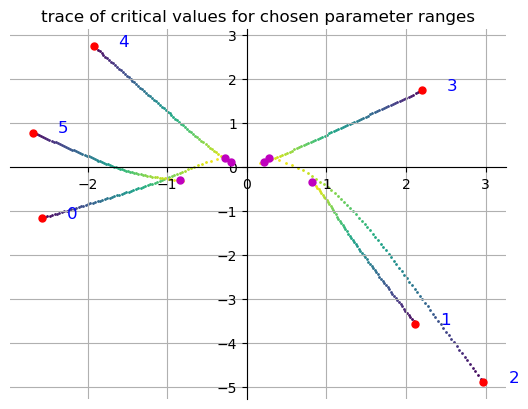

In [114]:
a_path = pl_path([2,I], steps=70)
b_path = pl_path([I,0], steps=70)

rho_params = {'a': a_path, 'b': b_path}

crits = parameterized_rho_crits(rho, rho_params)
plot_paths(crits)


### Vanishing Cycles of Rho

#### Origin Fibre

7/128*z^3 + 53/256*z^2 - 9/16*z
[-5.61691708+0.j  0.        +0.j  1.8312028 +0.j]


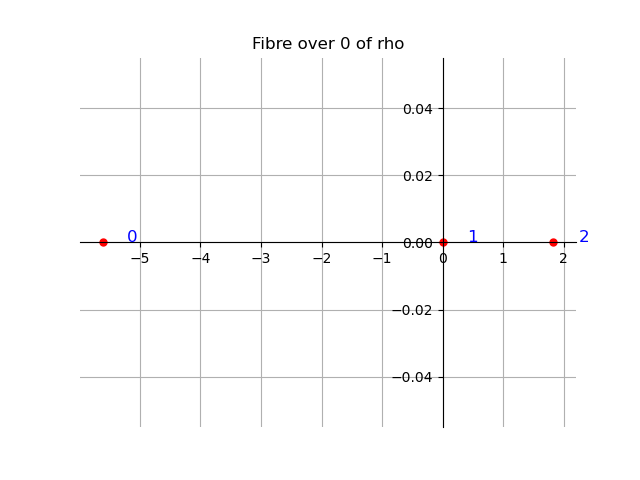

In [14]:
solvefor_rho = x

t_fibre_rho = rho.get_fibre(t,solvefor_rho)
fibre_rho_0 = t_fibre_rho.subs(t==origin_fibre_rho)
print(fibre_rho_0)

sols = NumericalRoots(fibre_rho_0)
print(sols)

plot_points_ordered(sols, origin_fibre=origin_fibre_rho, title="Fibre over 0 of rho")


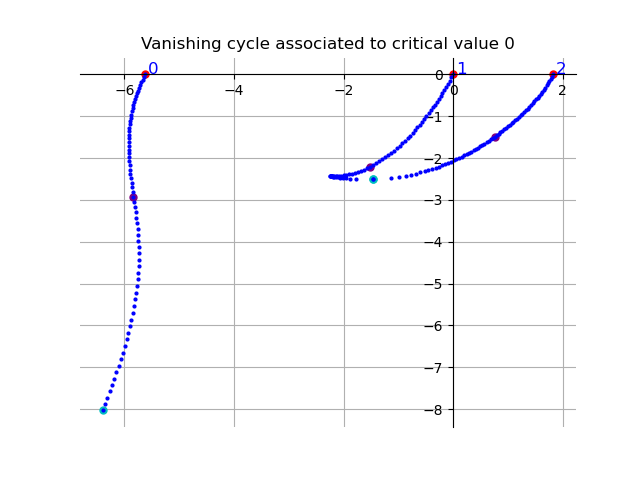

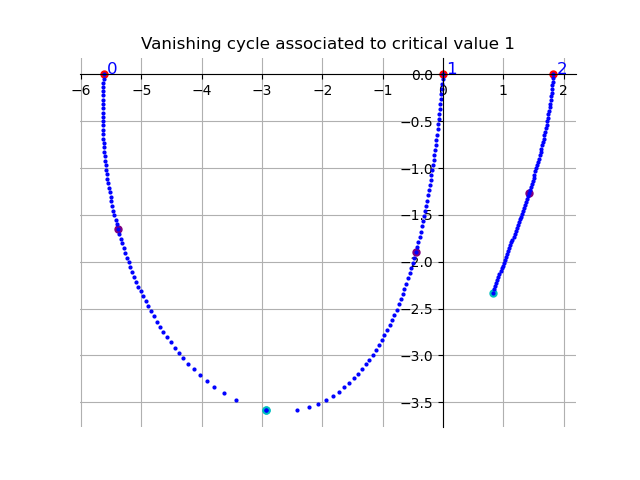

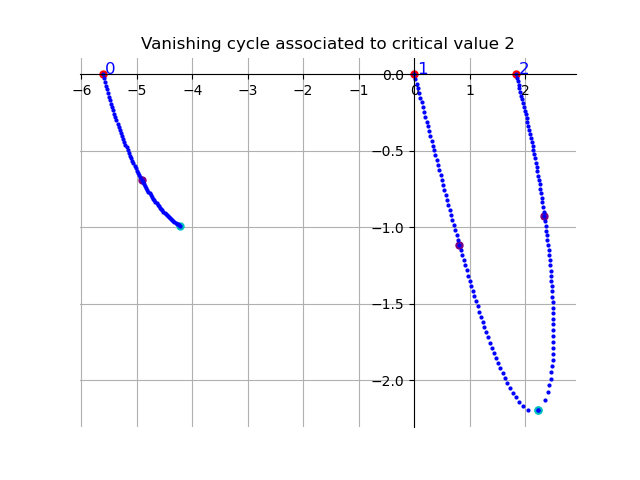

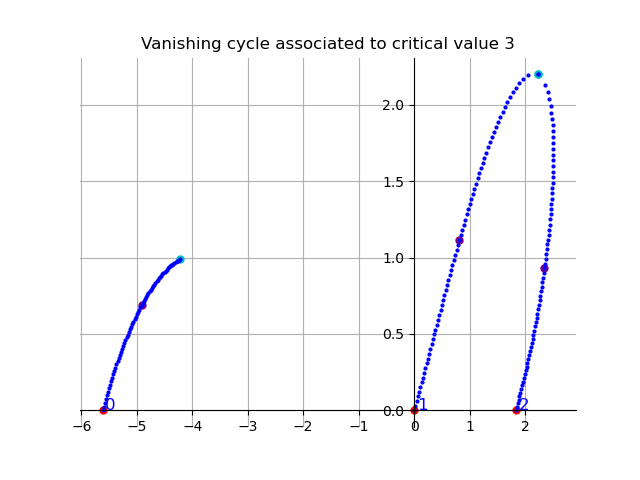

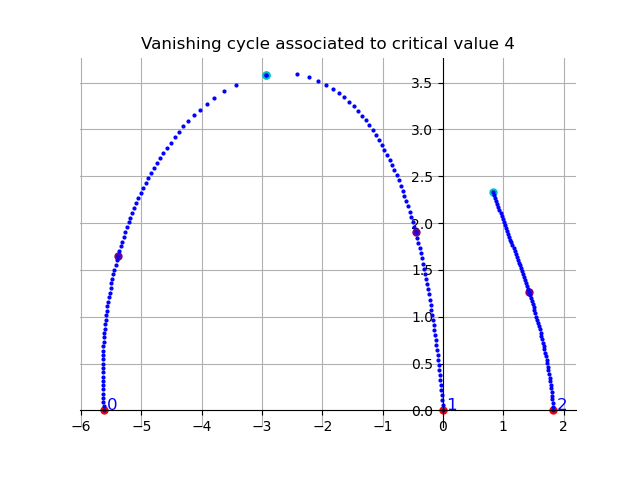

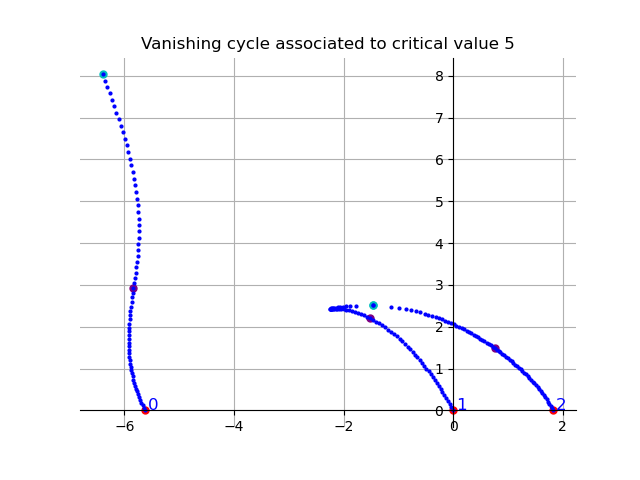

In [15]:
for (index, point) in enumerate(crit_values_rho):
    path = pl_path([origin_fibre_rho, point])
    trace_preimage(rho, t, path, solvefor=solvefor_rho, title=f'Vanishing cycle associated to critical value {index}')    

## Matching Paths - Images of Vanishing Cycles

In [16]:
for index, crit in enumerate(crit_values_pi):
    matching = pi.get_matching_path(rho_0, origin_fibre, crit, solvefor=solvefor, steps=70)

    plot_path_3d(matching, title = f'Matching path to critical value {index} of f', origin_fibre=origin_fibre)

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object